# 0.3.1 Comparing Accuracy Metrics

The accuracy results that we've been getting so far haven't reflected the those presented in O'Reilly's paper, so let's generate them more systematically.

## Boilerplate

The following subsections are largely boilerplate code, so skip around as needed.

### Jupyter Extensions

Load [watermark](https://github.com/rasbt/watermark) to see the state of the machine and environment that's running the notebook. To make sense of the options, take a look at the [usage](https://github.com/rasbt/watermark#usage) section of the readme.

In [1]:
# Load `watermark` extension
%load_ext watermark
# Display the status of the machine and packages. Add more as necessary.
%watermark -v -n -m -g -b -t -p numpy,matplotlib,seaborn,tensorflow

Sun Mar 10 2019 15:15:54 

CPython 3.6.8
IPython 7.3.0

numpy 1.16.2
matplotlib 3.0.3
seaborn 0.9.0
tensorflow 1.12.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.4.0-130-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 12
interpreter: 64bit
Git hash   : c78d1b5e16d1a927fca67905d23089041445c4fd
Git branch : master


Load [autoreload](https://ipython.org/ipython-doc/3/config/extensions/autoreload.html) which will always reload modules marked with `%aimport`.

This behavior can be inverted by running `autoreload 2` which will set everything to be auto-reloaded *except* for modules marked with `%aimport`.

In [2]:
# Load `autoreload` extension
%load_ext autoreload
# Set autoreload behavior
%autoreload 1

Load `matplotlib` in one of the more `jupyter`-friendly [rich-output modes](https://ipython.readthedocs.io/en/stable/interactive/plotting.html). Some options (that may or may not have worked) are `inline`, `notebook`, and `gtk`.

In [3]:
# Set the matplotlib mode.
%matplotlib inline

### Imports

Static imports that shouldn't necessarily change throughout the notebook.

In [4]:
# Standard library imports
from ast import literal_eval
import os
import logging

# Third party
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

Local imports that may or may not be autoreloaded. This section contains things that will likely have to be re-imported multiple times, and have additions or subtractions made throughout the project.

In [5]:
# Task script
%aimport leabratf.tasks.combinatorics.combigen
import leabratf.tasks.combinatorics.combigen as cg
# Visualization for the task
%aimport leabratf.visualization.combigen_heatmap
import leabratf.visualization.combigen_heatmap as cgh
# Utility functions
%aimport leabratf.utils
from leabratf.utils import setup_logging
%aimport leabratf.constants
from leabratf.constants import DIR_MODELS

### Initial Setup

Set [seaborn defaults](https://seaborn.pydata.org/generated/seaborn.set.html) for matplotlib.

In [6]:
sns.set()
sns.set_context("notebook")

Set up the logger configuration to something more useful than baseline. Creates log files for the different log levels in the `logs` directory.

See `logging.yml` for the exact logging configuration.

In [7]:
# Run base logger setup
setup_logging()
# Define a logger object
logger = logging.getLogger('leabratf')
# Don't propagate messages
logger.propagate = False

tf.logging.set_verbosity(logging.INFO)

### Global Variables

#### Combigen Task Variables

In [8]:
# Number of slots in a training set
STACK = 4
# Size of each axis in the input array
SIZE = 5
# Number of axes to use per slot
DIMS = 2
# Number of lines per axis
LINES = [1,1]

#### Data Parameters

In [9]:
# Number of epochs to train for
EPOCHS = 500
# Number of samples in the training set
N_TRAIN= 100
# Number of samples in the validation set
N_VAL = 50
# Number of samples in the testing set
N_TEST = 500

#### Datasets

In [10]:
# Training Data
Y_TRAIN = cg.generate_labels(n_samples=N_TRAIN, stack=STACK, size=SIZE, dims=DIMS, n_lines=LINES)
X_TRAIN = cg.inverse_transform(Y_TRAIN)
# Validation Data
Y_VAL = cg.generate_labels(n_samples=N_VAL, stack=STACK, size=SIZE, dims=DIMS, n_lines=LINES)
X_VAL = cg.inverse_transform(Y_VAL)
# Testing data
Y_TEST = cg.generate_labels(n_samples=N_TEST, stack=STACK, size=SIZE, dims=DIMS, n_lines=LINES)
X_TEST = cg.inverse_transform(Y_TEST)

#### Network Parameters

In [11]:
# Learning rate
ALPHA = 0.01
# Batch size
BATCH_SIZE = 1
# Number of parameters in the inputs
N_INPUTS = STACK * SIZE ** DIMS
# Number of hidden units
N_HIDDEN_1 = 100
# Number of parameters in the labels
N_OUTPUTS = STACK * SIZE * DIMS

#### Training Parameters

In [12]:
# Number of times to print an update
N_UPDATES = 5
# Which device to train on
TF_DEVICE = '/cpu:0'
# Number of models to train with
N_MODELS = 10

## Background

This section goes over some of the background information for the notebook using results from previous notebooks. Skip around as needed.

### The Combigen Task

Quickly remind ourselves what the task looks like before diving in.

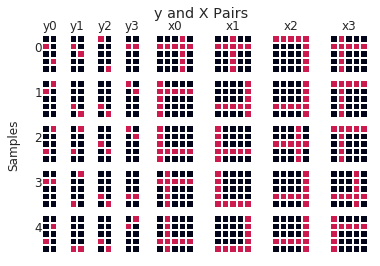

In [13]:
cgh.visualize_combigen(5)
plt.show()

### Previous Accuracy Results

Between nb-0.2.x and 0.3, our accuracy results have been quite reproducible. Here is a summary of the different results so far. All of the models shown below were trained using the O'Reilly BP architecture and binary cross-entropy as the loss. 

#### Elemental Accuracy

In nb-0.2.x, the O'Reilly BP model was implemented in keras using an absolute error based accuracy metric. Below is the training curve when trained to 5000 epochs.

![BCE_SGD](images/nb0.2.1_bce_sgd_5000_epochs.png)

#### Sample Accuracy

In nb-0.3, the model was implemented in tensorflow with a modification to the accuracy
Some things to note are that the models were trained to 10 times the number of epochs as O'Reilly did (500). However, a dotted vertical line was added at the 500 epoch mark to make it clear what the model's performance would have looked like.

## Obtaining the Metrics

This next section will define the computational graph that will be used to generate the metrics down below. It is largely code copied from nb-0.3, so skip around as needed.

In [13]:
# Cleanup any residual nodes
tf.reset_default_graph()

### Make the Datasets

Define the various `tf.Dataset`s that will be used.

In [14]:
def make_tf_datasets(init_ops):
    # The first step of the setup is that each of the datasets (training, validation, and 
    # testing) are turned into their own `Dataset` objects.
    # Training dataset
    dataset_train = tf.data.Dataset.from_tensor_slices(
        (X_TRAIN, Y_TRAIN)).repeat().batch(BATCH_SIZE)
    # Validation dataset
    dataset_val = tf.data.Dataset.from_tensor_slices(
        (X_VAL, Y_VAL)).repeat().batch(N_VAL)
    # Testing dataset
    dataset_test = tf.data.Dataset.from_tensor_slices(
        (X_TEST, Y_TEST)).repeat().batch(N_TEST)
    
    # Next, let's define the iterators for each of the datasets, and then add their 
    # initializations to the `init_ops` list.
    # Training iterator
    train_iter = dataset_train.make_initializable_iterator()
    # Validation iterator
    val_iter = dataset_val.make_initializable_iterator()
    # Testing iterator
    test_iter = dataset_test.make_initializable_iterator()
    # Aggregate the iterators
    iterators = [train_iter, val_iter, test_iter]

    # Add the initiatlizations to the init opts
    init_ops += [train_iter.initializer, val_iter.initializer, test_iter.initializer]
    
    # And finally, the interesting part. Rather than creating separate next elements for 
    # the model, the `tf.data` API has a string handler iterator so we can contextually 
    # switch the active `Dataset` object, resulting in different values being used for `x` 
    # and `y`.

    # The way this is done is by defining a `tf.placeholder` variable, which is used 
    # first to create a string handler iterator, and later to hold the dataset-indicating 
    # string handle. The string handler iterator is what then changes the values of `x` and 
    # `y`, naturally also supplying them using the `get_next` method.
    # The placeholder variable of type string
    handle = tf.placeholder(tf.string, shape=[])
    # Iterator from string handle
    handle_iterator = tf.data.Iterator.from_string_handle(
        handle, dataset_train.output_types, 
        dataset_train.output_shapes)

    # x and y that will be used in the graph
    x, y = handle_iterator.get_next()
    
    return x, y, iterators, handle, init_ops

### TF Variables

Straight forward section where we define the weights and biases. One thing to note is that the weights are initialized using the `tf.contrib.layers.xavier_initializer`. 

Additionally, create an empty list that will contain the initialization operations to be performed at the start of a session.

In [15]:
# Weights and biases
weights = {
    'h1': tf.get_variable(name='w_h1', shape=[N_INPUTS, N_HIDDEN_1],
                      initializer=tf.contrib.layers.xavier_initializer()),
    'out': tf.get_variable(name='w_out', shape=[N_HIDDEN_1, N_OUTPUTS],
                      initializer=tf.contrib.layers.xavier_initializer()),
}
biases = {
    'b1': tf.get_variable(name="b_1", shape=[N_HIDDEN_1], 
                      initializer=tf.zeros_initializer()),
    'out': tf.get_variable(name="b_out", shape=[N_OUTPUTS], 
                      initializer=tf.zeros_initializer()),
}

# List for initialization operations
init_ops = [tf.global_variables_initializer()]

### Model and Loss Function

The architecture is the same as previous notebooks. See nb-0.3 for more details.

In [16]:
def oreilly_model(inputs):
    # Reshape for hidden layer
    inputs = tf.reshape(inputs, shape=[-1, N_INPUTS])
    # Single hidden layer
    inputs = tf.sigmoid(tf.add(tf.matmul(inputs, weights['h1']), biases['b1']))
    # Output layer
    inputs = tf.add(tf.matmul(inputs, weights['out']), biases['out'])
    # Reshape for labels
    return tf.reshape(inputs, shape=[-1, STACK, SIZE, DIMS])

with tf.device(TF_DEVICE):
    # Get the relevant dataset nodes
    x, y, iterators, handle, init_ops = make_tf_datasets(init_ops)
    
    # Build the model
    logits = oreilly_model(x)
    # Ensure y is cast to the same type as logits
    labels = tf.cast(y, logits.dtype)

    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=logits, labels=labels))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=ALPHA)

    # train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    train_op = optimizer.minimize(loss_op)

### Metrics

The last few ops to define before training are the metrics. 

In [17]:
with tf.device(TF_DEVICE):
    # Define some intermediate nodes
    predictions = tf.sigmoid(logits)
    rounded_predictions = tf.round(predictions)
    equal_labels_and_preds = tf.equal(rounded_predictions, labels)
    
    # O'Reilly Accuracy 
    axis_acc = tf.reduce_all(equal_labels_and_preds, axis=(2))
    slot_acc = tf.reduce_all(axis_acc, axis=(2))
    sample_acc = tf.reduce_all(slot_acc, axis=(1))
 
    # Elemental Accuracy 
    el_acc_op = tf.reduce_mean(tf.cast(equal_labels_and_preds, tf.float16))
    # Axis Accuracy
    axis_acc_op = tf.reduce_mean(tf.cast(axis_acc, tf.float16))
    # Slot Accuracy
    slot_acc_op = tf.reduce_mean(tf.cast(slot_acc, tf.float16))
    # Sample Accuracy
    sample_acc_op = tf.reduce_mean(tf.cast(sample_acc, tf.float16))

### New Session Function

In the event that we do not want to immediately close sessions, we won't be using the context handler but will still need to grab new sessions as necessary. So let's quickly write a function that will properly run `sess.close()` if a previous session exists and then return a new `tf.Session` instance.

In [18]:
def new_session(*args, **kwargs):
    # Try to close the globally defined session if it isn't already
    try:
        if not sess._closed:
            sess.close()
    # If it doesn't exist, then just pass
    except NameError:
        pass
    # Return the new instance
    return tf.Session(*args, **kwargs)

### Defining the Training Function

Let's define a function that runs the training routine and accepts the number of epochs as the inputs.

In [19]:
def train_or_model(sess, epochs=EPOCHS, n_updates=N_UPDATES):
    # Ensure this is an int
    epochs = int(epochs)
    # Dict with the various metrics we care about
    metrics = {'loss':[], 'el_acc':[], 'ax_acc':[], 'sl_acc':[], 'sm_acc':[], 
               'val_loss':[], 'val_el_acc':[], 'val_ax_acc':[], 'val_sl_acc':[], 
               'val_sm_acc':[]}
    # Run the initialization ops
    sess.run(init_ops)
    # Define training and validation handlers
    training_handle, validation_handle, testing_handle = sess.run([i.string_handle() 
                                                                   for i in iterators])

    for epoch in range(epochs):
        ep_loss, ep_el_acc, ep_sl_acc, ep_ax_acc, ep_sm_acc = np.zeros([5, N_TRAIN])
        # Run the training steps
        for i in range(N_TRAIN):
            _, ep_loss[i], ep_el_acc[i], ep_sl_acc[i], ep_ax_acc[i], ep_sm_acc[i] = sess.run(
                [train_op, loss_op, el_acc_op, axis_acc_op, slot_acc_op, sample_acc_op],
                feed_dict={handle: training_handle})
            
        # Get means for the epoch
        epoch_data = list(np.mean((ep_loss, ep_el_acc, ep_sl_acc, ep_ax_acc, ep_sm_acc), 
                                  axis=1))

        # Calculate validation accuracy and loss
        val_data = list(sess.run([loss_op, el_acc_op, axis_acc_op, slot_acc_op, sample_acc_op],
                                 feed_dict={handle: validation_handle}))
        
        # Record
        for key, value in zip(metrics.keys(), epoch_data + val_data):
            metrics[key].append(value)

        # Selectively display the epoch number
        if not epoch % (epochs / n_updates) or epoch == epochs - 1:
            print(("Completed epoch {0}/{1}. Metrics:\n" + 
                   "                     Loss   Sample Accuracy   Elem Accuracy\n" +
                   "    Epoch:      {2:10.4f}   {3:10.4f}   {4:10.4f}\n" +
                   "    Validation: {5:10.4f}   {6:10.4f}   {7:10.4f}\n").format(
                epoch+1, epochs, epoch_data[0],epoch_data[4], epoch_data[1], 
                val_data[0], val_data[4], val_data[1]))

    # Calculate accuracy for test images
    print("Optimization Finished! Testing Accuracy:", sess.run(
        accuracy_op, feed_dict={handle: testing_handle}))
    return metrics

### Getting Metrics for 10 Models

The last thing to do is encapsulate everything into one list.

In [55]:
%%time
sess = new_session()
metrics = []
for i in range(N_MODELS):
    print('Starting training for model {0}...'.format(i))
    metrics.append(train_or_model(sess, epochs=50*EPOCHS, n_updates=1))
    print('Completed training for model {0}!\n'.format(i))

Starting training for model 0...
Completed epoch 1/25000. Metrics:
                     Loss   Sample Accuracy   Elem Accuracy
    Epoch:          0.6657       0.0000       0.5955
    Validation:     0.6367       0.0000       0.6450

Completed epoch 25000/25000. Metrics:
                     Loss   Sample Accuracy   Elem Accuracy
    Epoch:          0.0025       1.0000       1.0000
    Validation:     0.0635       0.3999       0.9766

Optimization Finished! Testing Accuracy: 0.454
Completed training for model 0!

Starting training for model 1...
Completed epoch 1/25000. Metrics:
                     Loss   Sample Accuracy   Elem Accuracy
    Epoch:          0.7226       0.0000       0.5315
    Validation:     0.6821       0.0000       0.5732

Completed epoch 25000/25000. Metrics:
                     Loss   Sample Accuracy   Elem Accuracy
    Epoch:          0.0025       1.0000       1.0000
    Validation:     0.0618       0.4199       0.9771

Optimization Finished! Testing Accuracy: 0

And then now let's put everything in one pandas dataframe.

In [46]:
metrics_df = pd.DataFrame(metrics)

In the event that the data needs to be reloaded (for example if the kernel needs to be restarted), I have the data saved locally and can be reloaded using the following lines:

```
from leabratf.constants import DIR_LOGS
metrics_df = pd.read_csv(str(DIR_LOGS / '10_models_25000_epochs.csv'), index_col=0)
```

## Plotting the Metrics

Just like before, let's plot the training curves using the metrics we obtained. To do this, let's borrow the same function from nb-0.3 but make it a bit more general.

In [16]:
def plot_metrics(metrics_df, metrics=None, epochs=None, title=None, key_by_model=False, model_average=False):
    # What metrics to plot
    metrics = metrics or metrics_df.columns
    # Empty lists for the long form data
    long_epochs, long_metrics, long_hues, long_units = [], [], [], []
    
    # Loop through each model's data
    for i, metrics_series in metrics_df.iterrows():
        # Series data is in a string format, convert to floats and put them in a dict
        metrics_dict = {key: [float(val) for val in literal_eval(metrics_series[key])]
                        for key in metrics}
        
        # How many epochs to plot
        if not epochs:
            len_metrics = [len(val) for val in metrics_dict.values()]
            assert all(l == len_metrics[0] for l in len_metrics), 'Metrics have different lengths'
            epochs = len_metrics[0]

        # Add to the long form lists
        for key in metrics:
            label = key if not key_by_model else 'Model {0}'.format(i)
            units = i if not key_by_model else key
            long_epochs += list(range(epochs))
            long_metrics += metrics_dict[key][:epochs]
            long_hues += [label]*epochs
            long_units += [units]*epochs

    if model_average:
        sns.lineplot(x=long_epochs, y=long_metrics, hue=long_hues, 
                     estimator='mean')
    # Plot each line individually
    else:
        sns.lineplot(x=long_epochs, y=long_metrics, hue=long_hues, 
                     estimator=None, units=long_units)

    # Title, axis, and 500 epoch line
    plt.title(title or 'Training History')
    plt.xlabel('Epochs')
    if epochs > EPOCHS:
        plt.axvline(EPOCHS, linestyle='--', label='500 Epochs')
        
    # Prune down the number of labels to just the unique ones
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    
    # Make the plot twice as large to make things a little more viewable
    gcf = plt.gcf()
    gcf.set_size_inches(*[size*2 for size in gcf.get_size_inches()])

### The Legend

Now that we have so may metrics to keep track of, it's worth taking the time to define each of them.

#### Training Set Metrics

Metrics obtained every epoch from from performance on the training set.

- `loss` - Loss for the training set
- `el_acc` - Element-wise accuracy between predictions and labels for the training set
- `ax_acc` - Axis accuracy for each slot in each sample between predictions and labels for the training set. Score per sample goes in eighth steps between 0.0 and 1.0. Every correct axis in every slot contributes 0.125 to the the overall accuracy
- `sl_acc` - Slot accuracy for sample between predictions and labels for the training set. Score per sample goes in quarter steps between 0.0 and 1.0. Any slot that has all elements correct contributes 0.25 to the score
- `sm_acc` - Sample accuracy between predictions and labels for the training set. Score per sample is binary - model must get every element correct to receive 1.0

#### Validation Set Metrics

Metrics obtained every epoch from from performance on the validation set.

- `val_loss` - Loss for the validation set for a particular epoch
- `val_el_acc` - Element-wise accuracy between predictions and labels for the validation set. See above for details
- `val_sl_acc` - Slot accuracy for sample between predictions and labels for the validation set. See above for details
- `val_sm_acc` - Sample accuracy between predictions and labels for the training set. See above for details

## Summary Plots

The following two plots have summaries of all the data collected.

### All Metrics for All Models

Let's plot all the metrics for all the models to see what they all generally look like.

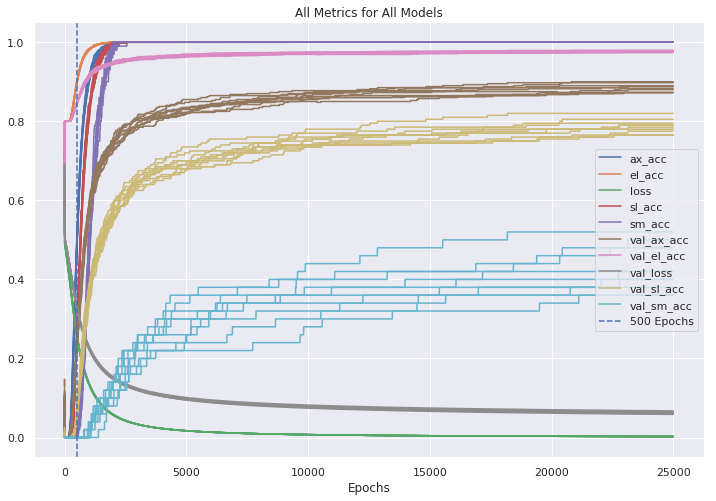

CPU times: user 1min 18s, sys: 1.84 s, total: 1min 20s
Wall time: 43.4 s


In [26]:
%%time
# These are the possible metrics to use
# ['loss', 'el_acc', 'ax_acc', 'sl_acc', 'sm_acc', 'val_loss', 
#  'val_el_acc', 'val_ax_acc', 'val_sl_acc', 'val_sm_acc']
plot_metrics(metrics_df, 
             metrics=None, 
             epochs=None,
             title='All Metrics for All Models',
             key_by_model=False,
             model_average=False)
plt.show()

### Average Metrics for All Models

Let's also plot the average metric values across all 10 models.

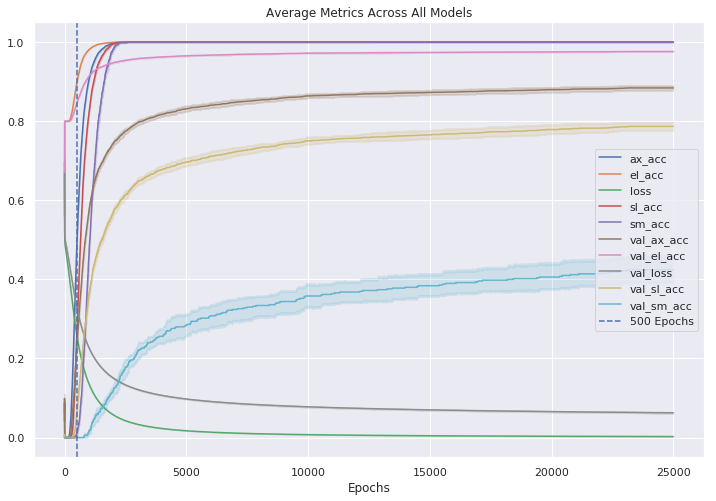

CPU times: user 1h 35min 4s, sys: 4min 23s, total: 1h 39min 28s
Wall time: 1h 38min 36s


In [27]:
%%time
# These are the possible metrics to use
# ['loss', 'el_acc', 'ax_acc', 'sl_acc', 'sm_acc', 'val_loss', 
#  'val_el_acc', 'val_ax_acc', 'val_sl_acc', 'val_sm_acc']
plot_metrics(metrics_df, 
             metrics=None, 
             epochs=None,
             title='Average Metrics Across All Models',
             key_by_model=False,
             model_average=True)`
plt.show()

Note the execution time difference between the two plots.

## Accuracy Metrics in Detail

Let's go through each of the different accuracy metrics individually.

### Average Loss and Elemental Accuracy

These are plots we have already generated in the past so let's just start with them. Since they also asymptote relatively quickly, let's only plot the first 2000 epochs, and also average them since they don't vary much between models.

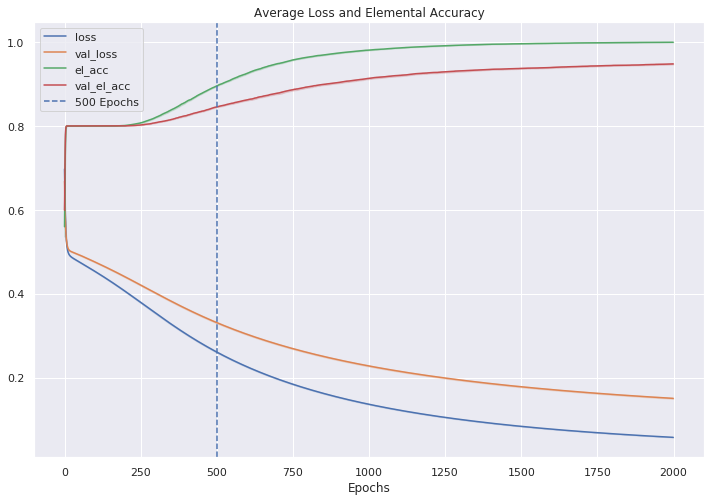

CPU times: user 2min 57s, sys: 8.61 s, total: 3min 6s
Wall time: 3min 6s


In [83]:
%%time
# These are the possible metrics to use
# ['loss', 'el_acc', 'ax_acc', 'sl_acc', 'sm_acc', 'val_loss', 
#  'val_el_acc', 'val_ax_acc', 'val_sl_acc', 'val_sm_acc']
plot_metrics(metrics_df, 
             metrics=['loss', 'val_loss', 'el_acc', 'val_el_acc'], 
             epochs=2000,
             title='Average Loss and Elemental Accuracy',
             key_by_model=False,
             model_average=True)
plt.show()

### Average Training Axis and Slot Accuracy

Next let's take a look at the training axis and slot accuracy, which also level off relatively quickly (by around 2000 epochs).

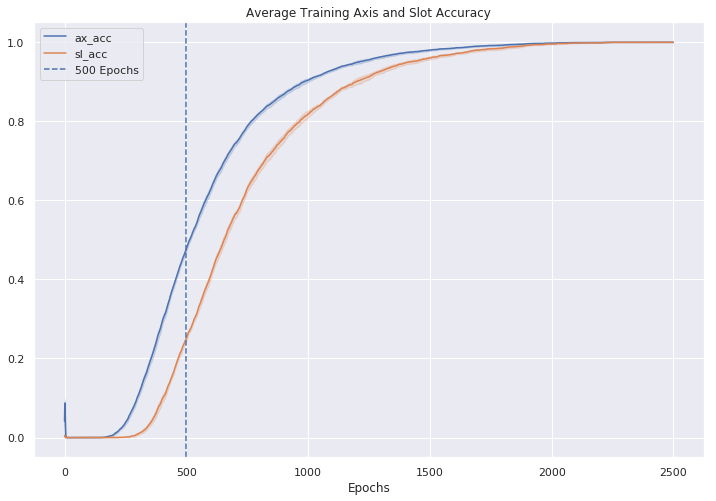

CPU times: user 1min 50s, sys: 5.54 s, total: 1min 55s
Wall time: 1min 55s


In [84]:
%%time
# These are the possible metrics to use
# ['loss', 'el_acc', 'ax_acc', 'sl_acc', 'sm_acc', 'val_loss', 
#  'val_el_acc', 'val_ax_acc', 'val_sl_acc', 'val_sm_acc']
plot_metrics(metrics_df, 
             metrics=['ax_acc', 'sl_acc',], 
             epochs=2500,
             title='Average Training Axis and Slot Accuracy',
             key_by_model=False,
             model_average=True)
plt.show()

### Validation Accuracy Metrics

The validation curves are where the curves for training are most revealing. So let's plot them all in one graph in the first 10,000 epochs.

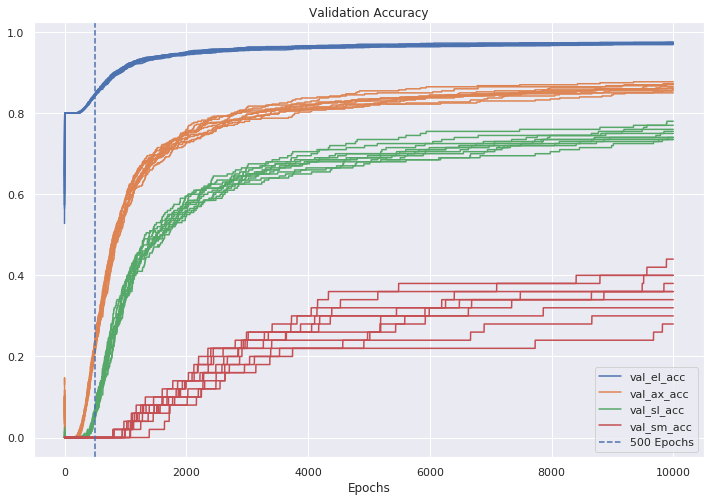

CPU times: user 17.2 s, sys: 312 ms, total: 17.5 s
Wall time: 8.51 s


In [23]:
%%time
# These are the possible metrics to use
# ['loss', 'el_acc', 'ax_acc', 'sl_acc', 'sm_acc', 'val_loss', 
#  'val_el_acc', 'val_ax_acc', 'val_sl_acc', 'val_sm_acc']
plot_metrics(metrics_df, 
             metrics=['val_el_acc', 'val_ax_acc', 'val_sl_acc', 'val_sm_acc'], 
             epochs=10000,
             title='Validation Accuracy',
             key_by_model=False,
             model_average=False)
plt.show()

Validation axis and slot accuracy begin asymptotic ascent around 4000 epochs never approach 1.0 the way it does for the training data. The slot accuracy also levels off at a lower point than the axis accuracy.

### Validation Sample Accuracy

The most interesting metric seems to definitely be the sample accuracy, which has the most diverse behavior of all the metrics. So let's plot it for all the models.

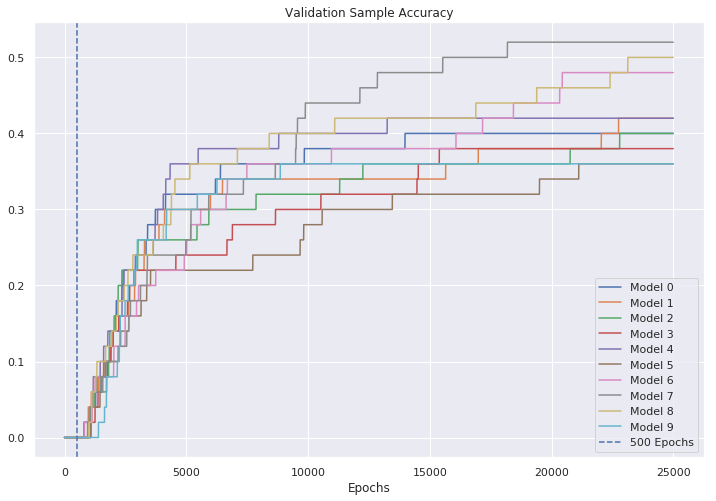

CPU times: user 3.82 s, sys: 92 ms, total: 3.92 s
Wall time: 3.91 s


In [24]:
%%time
# These are the possible metrics to use
# ['loss', 'el_acc', 'ax_acc', 'sl_acc', 'sm_acc', 'val_loss', 
#  'val_el_acc', 'val_ax_acc', 'val_sl_acc', 'val_sm_acc']
plot_metrics(metrics_df, 
             metrics=['val_sm_acc'], 
             epochs=None,
             title='Validation Sample Accuracy',
             key_by_model=True,
             model_average=False)
plt.show()